In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import configs
import tasks
import manifold_synthetic
import utils
import os
import pandas as pd
import pickle
import seaborn as sns

from ripser import Rips
from persim import plot_diagrams, bottleneck

In [2]:
args = configs.arg_parse_for_notebook().parse_args("--experiment syn_circle --no-points 400 --data-noise 0.001 --sampler-noise 0.01".split())

---Generate circle data


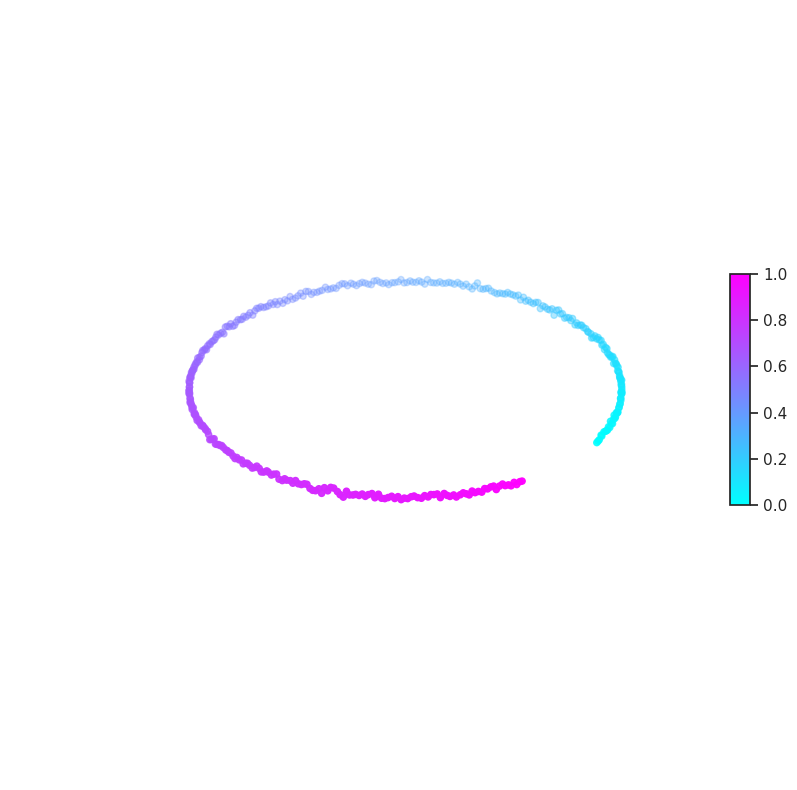

In [23]:
print("---Generate circle data")
n = args.no_points
r = 1
# phi = np.pi / 6 # "tilt" of the circle for visuzalization
phi = 0
noise = args.data_noise
fold = 4
# noise = 0

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
theta = np.linspace(0, 2*np.pi-0.5, n)
zvert = np.linspace(0, 0, n)

label = np.linspace(0, 1, n)

xdata = r*np.cos(theta) + noise * np.random.randn(n)
ydata = r*np.sin(theta)*np.cos(phi) + noise * np.random.randn(n)
zdata = r*np.sin(theta)*np.sin(phi) + noise * np.random.randn(n)
p = ax.scatter3D(xdata, ydata, zdata, c=label, cmap='cool');
ax.axes.set_zlim3d(bottom=-0.1, top=0.1) 
cax = fig.add_axes([ax.get_position().x1-0.05, ax.get_position().y0 *3.5, 0.02, ax.get_position().height * 0.3])
plt.colorbar(p, cax=cax) # Similar to fig.colorbar(im, cax = cax)

ax.axis('off')

# from mpl_toolkits.axes_grid1 import make_axes_locatable

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

# fig.colorbar(p, ax=cax)
plt.savefig('viz/syn_C.pdf')

In [24]:
fold = 10
train_data = []
label_data = []
for _ in range(fold):
    xdata = r*np.cos(theta) + noise * np.random.randn(n)
    ydata = r*np.sin(theta)*np.cos(phi) + noise * np.random.randn(n)
    zdata = r*np.sin(theta)*np.sin(phi) + noise * np.random.randn(n)
#     zdata = r*np.sin(theta)*np.sin(phi) 
    data = np.transpose(np.concatenate(([xdata],[ydata],[zdata]), axis=0))
    train_data.append(data)
    label_data.append(np.linspace(0, 1, n))
    

In [25]:
traindata = np.vstack(train_data)
trainlabel = np.concatenate(label_data)

In [26]:
import torch.nn as nn
 
# Define the model
model = nn.Sequential(
    nn.Linear(3, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
#     nn.Linear(12, 6),
#     nn.ReLU(),
    nn.Linear(10, 1)
)

In [27]:
import torch.nn as nn
import torch.optim as optim
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [28]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(traindata, trainlabel, train_size=0.8, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 1000   # number of epochs to run
batch_size = 100  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

In [29]:
print("MSE: %.5f" % best_mse)
print("RMSE: %.5f" % np.sqrt(best_mse))
# plt.plot(history)
# plt.show()

MSE: 0.00000
RMSE: 0.00060


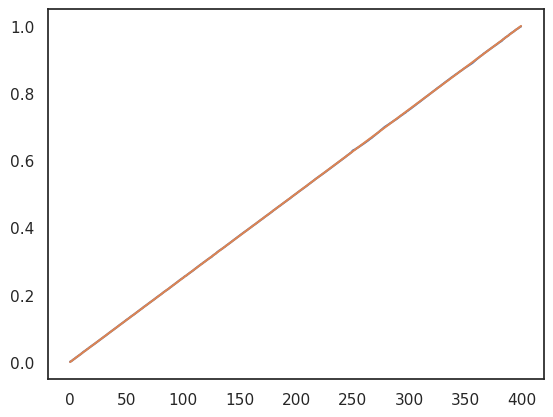

In [30]:
label_hat = model(torch.Tensor(data))

plt.plot(label_hat.detach())
plt.plot(label)

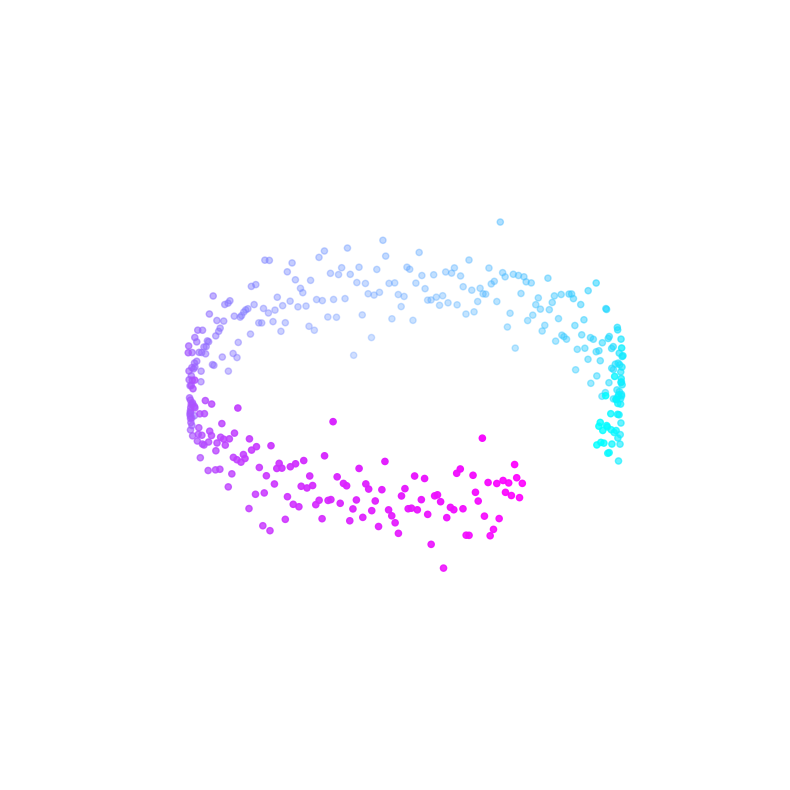

In [60]:
n = args.no_points
noise = args.data_noise

theta_o = np.linspace(0, 2*np.pi-0.5, n)
noise_z = 0.25
zvert_o = np.linspace(0, 0, n)

xdata_o = r*np.cos(theta_o) + noise * np.random.randn(n)
ydata_o = r*np.sin(theta_o)*np.cos(phi) + noise * np.random.randn(n)
zdata_o = r*np.sin(theta_o)*np.sin(phi) + noise_z * np.random.randn(n) + zvert_o

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xdata_o, ydata_o, zdata_o, c=theta_o, cmap='cool');
ax.axes.set_zlim3d(bottom=-1.6, top=1.6) 

ax.axis('off')

plt.savefig('viz/syn_Co_025.jpeg')

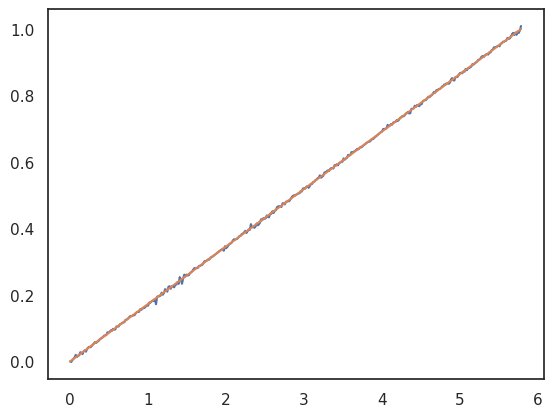

In [32]:
data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
label_o_hat = model(torch.Tensor(data_o))

plt.plot(theta_o, label_o_hat.detach())
plt.plot(theta_o, label)

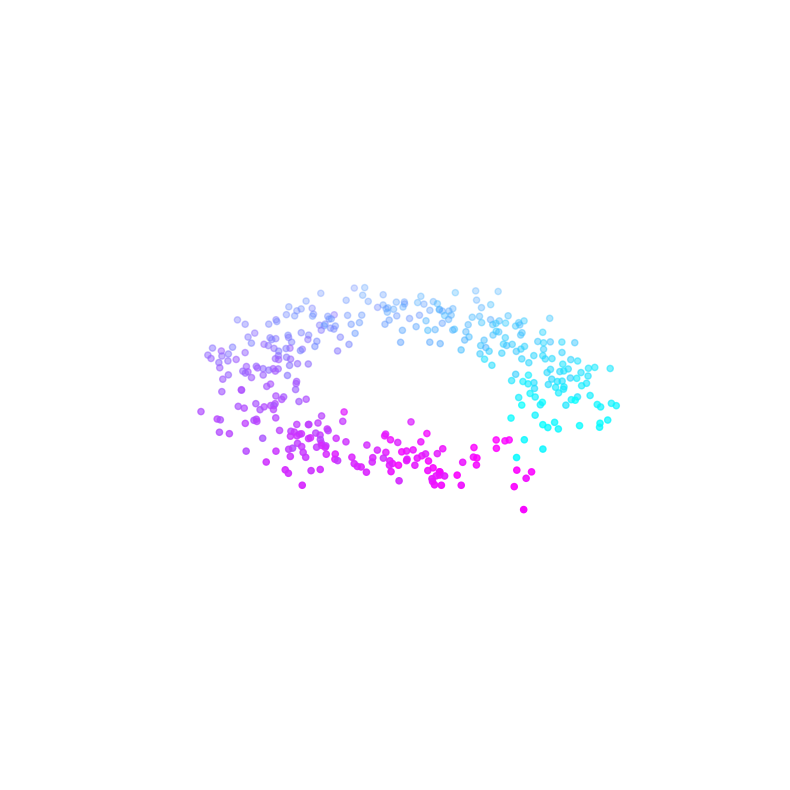

In [61]:
theta_o = np.linspace(0, 2*np.pi-0.5, n)
noise_x = noise_z/np.sqrt(2)
noise_y = noise_z/np.sqrt(2)
zvert_o = np.linspace(0, 0, n)

xdata_o = r*np.cos(theta_o) + noise_x * np.random.randn(n)
ydata_o = r*np.sin(theta_o)*np.cos(phi) + noise_y * np.random.randn(n)
zdata_o = r*np.sin(theta_o)*np.sin(phi) + noise * np.random.randn(n) + zvert_o

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xdata_o, ydata_o, zdata_o, c=theta_o, cmap='cool');
ax.axes.set_zlim3d(bottom=-0.6, top=0.6) 

ax.axis('off')

plt.savefig('viz/syn_Cp_025.jpeg')

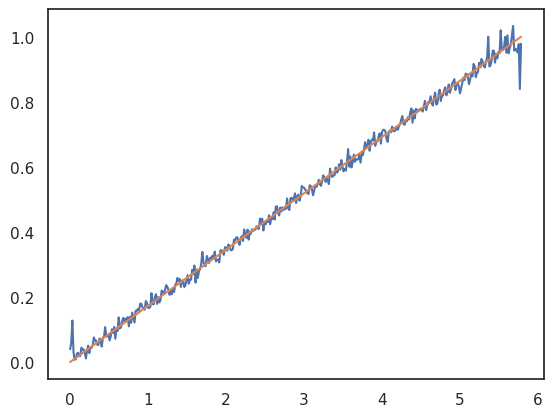

In [34]:
data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
label_o_hat = model(torch.Tensor(data_o))

plt.plot(theta_o, label_o_hat.detach())
plt.plot(theta_o, label)

In [19]:
# xdata_o = r*np.cos(theta_o) + (noise) * np.random.randn(n)
# ydata_o = r*np.sin(theta_o)*np.cos(phi) + (noise) * np.random.randn(n)
# zdata_o = r*np.sin(theta_o)*np.sin(phi) + noise * np.random.randn(n) 

# data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
# label_hat = model(torch.Tensor(data_o))

# plt.plot(label_hat.detach()) 

In [52]:
log_filename = 'results/synthetic_C_02.pkl'
# if os.path.isfile(log_filename):
#     result_log = pd.read_pickle(log_filename)
# else:
#     result_log = pd.DataFrame() 
n = 50
result_log = pd.DataFrame() 
no_runs = 100

theta_o = np.linspace(0, 2*np.pi-0.5, n)
noise_z = 0.01
noise_x = noise_z/np.sqrt(2)
noise_y = noise_z/np.sqrt(2)
zvert_o = np.linspace(0, 0, n)

xdata = r*np.cos(theta_o) + (noise) * np.random.randn(n)
ydata = r*np.sin(theta_o)*np.cos(phi) + (noise) * np.random.randn(n)
zdata = r*np.sin(theta_o)*np.sin(phi) + noise * np.random.randn(n) 

data_in = np.transpose(np.concatenate(([xdata],[ydata],[zdata]), axis=0))
label_hat = model(torch.Tensor(data_in))


for _ in range(no_runs):            
    xdata_o = xdata + noise_x * np.random.randn(n)
    ydata_o = ydata + noise_y * np.random.randn(n)
    zdata_o = zdata
#     xdata_o = r*np.cos(theta_o) + (noise_x)  + noise * np.random.randn(n)
#     ydata_o = r*np.sin(theta_o)*np.cos(phi) + (noise_y) + noise * np.random.randn(n)
#     zdata_o = r*np.sin(theta_o)*np.sin(phi) + noise * np.random.randn(n) 

    data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
    diff = model(torch.Tensor(data_o)) - label_hat
    diff = diff.detach().numpy()
#     diff = np.abs(diff)
#     diff = diff/np.sum(diff)

    for i in range(n):

        entry = {'Theta': theta_o[i],
                 'Pred': diff[i][0],
                 'Method': 'Projection'}

        result_log = pd.concat([result_log, pd.DataFrame.from_records([entry])])
        with open(log_filename, 'wb') as logfile:
            pickle.dump(result_log, logfile)
            
    xdata_o = xdata 
    ydata_o = ydata 
    zdata_o = zdata + noise_z * np.random.randn(n)
#     xdata_o = r*np.cos(theta_o) + noise * np.random.randn(n)
#     ydata_o = r*np.sin(theta_o)*np.cos(phi) + noise * np.random.randn(n)
#     zdata_o = r*np.sin(theta_o)*np.sin(phi) + (noise_z)  + noise * np.random.randn(n)
    
    data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
    diff = model(torch.Tensor(data_o)) - label_hat
    diff = diff.detach().numpy()
#     diff = np.abs(diff)
#     diff = diff/np.sum(diff)

    for i in range(n):

        entry = {'Theta': theta_o[i],
                 'Pred': diff[i][0],
                 'Method': 'Orthogonal'}

        result_log = pd.concat([result_log, pd.DataFrame.from_records([entry])])
        with open(log_filename, 'wb') as logfile:
            pickle.dump(result_log, logfile)

/scratch/local/3195203/ipykernel_10050/1647775304.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticks(), size = 13)
/scratch/local/3195203/ipykernel_10050/1647775304.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)


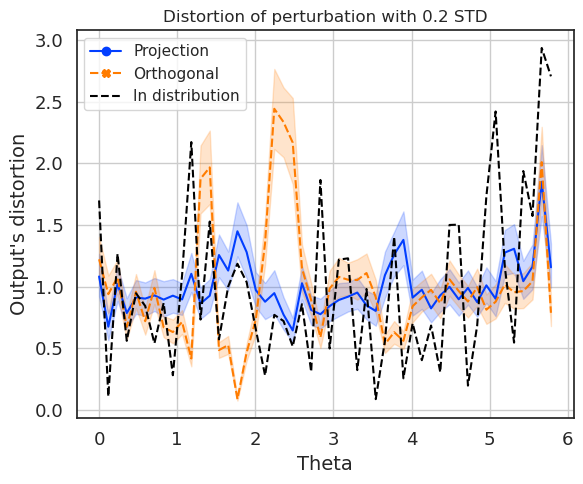

In [53]:
from matplotlib.ticker import NullFormatter

log_filename = 'results/synthetic_C_02.pkl'
# log_filename = 'results/synthetic_C_0.5.pkl'
if os.path.isfile(log_filename):
    result_log = pd.read_pickle(log_filename)
else:
    result_log = pd.DataFrame() 

result_log['Distortion'] = np.abs(result_log['Pred'])

otho_mean = result_log[result_log['Method'] == "Orthogonal"]["Distortion"].mean()
proj_mean = result_log[result_log['Method'] == "Projection"]["Distortion"].mean()
def normalize_distortion(row):  
    if row['Method'] == "Orthogonal":
        return row['Distortion']/otho_mean
    elif row['Method'] == "Projection":
        return row['Distortion']/proj_mean
    else:
        return 0
    
result_log['Distortion Normalized'] = result_log.apply(lambda row: normalize_distortion(row), axis=1)

plt.figure(figsize = (6,5))
sns.set(style='white',)

def formatter(x, pos):
    return str(int(x))

def formatter_y(x, pos):
    return str(round(x, 3))

g = sns.lineplot( x="Theta", y="Distortion Normalized", 
                     data=result_log, 
                     hue='Method',
                     style='Method',
#                      err_style="bars",
                     palette = 'bright',
                     markers=True, 
                     markersize=0,
                     legend=True)

g.set(title ='Distortion of perturbation with 0.2 STD')
g.set_xlabel(xlabel ="Theta", size = 14)
g.set_ylabel(ylabel ="Output's distortion", size = 14)
g.set_xticklabels(g.get_xticks(), size = 13)
g.set_yticklabels(g.get_yticks(), size = 13)

g.xaxis.set_major_formatter(formatter)
g.xaxis.set_minor_formatter(NullFormatter())
g.yaxis.set_major_formatter(formatter_y)
g.yaxis.set_minor_formatter(NullFormatter())

plt.grid()

# lgnd = g.legend(title='Input dim',
#           bbox_to_anchor=(1.0, 1.02), fontsize=13, facecolor="gray", framealpha=0.3)

noise = noise_z
# print(noise)
model.eval()
theta_o = np.linspace(0, 2*np.pi-0.5, n)

theta_inc = np.clip(theta_o + noise, 0, 2*np.pi-0.5)
theta_dec = np.clip(theta_o - noise, 0, 2*np.pi-0.5)

xdata_i = r*np.cos(theta_inc)
ydata_i = r*np.sin(theta_inc)*np.cos(phi) 
zdata_i = r*np.sin(theta_inc)*np.sin(phi) + zvert_o

data_i = np.transpose(np.concatenate(([xdata_i],[ydata_i],[zdata_i]), axis=0))
label_i_hat = model(torch.Tensor(data_i)).detach() 

xdata_i = r*np.cos(theta_dec)
ydata_i = r*np.sin(theta_dec)*np.cos(phi) 
zdata_i = r*np.sin(theta_dec)*np.sin(phi) + zvert_o

data_i = np.transpose(np.concatenate(([xdata_i],[ydata_i],[zdata_i]), axis=0))
label_j_hat = model(torch.Tensor(data_i)).detach() 

diff_i = torch.abs(label_i_hat - label_hat)
diff_j = torch.abs(label_j_hat - label_hat)

diff = torch.max(diff_j, diff_i)
diff = np.abs(diff.detach().numpy())

sns.lineplot(x = theta_o, y = diff[:,0]/np.mean(diff), 
             color="black", 
             linestyle='dashed',  
#              marker='s', markersize = 1,
#               sizes = 10, 
             label='In distribution'
            )

plt.tight_layout()

plt.savefig('viz/Diff_02.pdf')


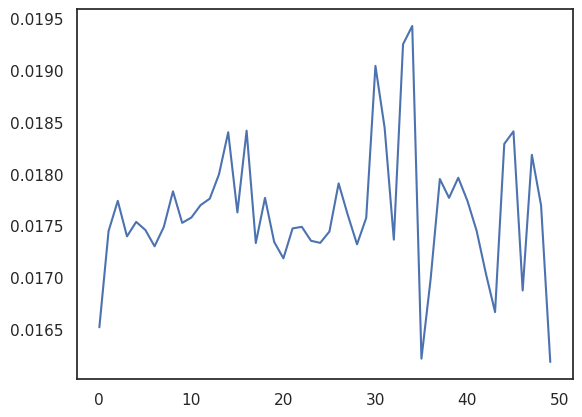

In [37]:
noise = noise_z
# print(noise)
model.eval()
theta_o = np.linspace(0, 2*np.pi-0.5, n)

theta_inc = np.clip(theta_o + noise, 0, 2*np.pi-0.5)
theta_dec = np.clip(theta_o - noise, 0, 2*np.pi-0.5)

xdata_i = r*np.cos(theta_inc)
ydata_i = r*np.sin(theta_inc)*np.cos(phi) 
zdata_i = r*np.sin(theta_inc)*np.sin(phi) + zvert_o

data_i = np.transpose(np.concatenate(([xdata_i],[ydata_i],[zdata_i]), axis=0))
label_i_hat = model(torch.Tensor(data_i)).detach() 

xdata_i = r*np.cos(theta_dec)
ydata_i = r*np.sin(theta_dec)*np.cos(phi) 
zdata_i = r*np.sin(theta_dec)*np.sin(phi) + zvert_o

data_i = np.transpose(np.concatenate(([xdata_i],[ydata_i],[zdata_i]), axis=0))
label_j_hat = model(torch.Tensor(data_i)).detach() 

diff_i = torch.abs(label_i_hat - label_hat)
diff_j = torch.abs(label_j_hat - label_hat)

diff = torch.max(diff_j, diff_i)
diff = np.abs(diff.detach().numpy())
# diff = diff/np.sum(diff)

plt.plot(diff) 

In [ ]:
log_filename = 'results/synthetic_C_01.pkl'
# if os.path.isfile(log_filename):
#     result_log = pd.read_pickle(log_filename)
# else:
#     result_log = pd.DataFrame() 
n = 50
result_log = pd.DataFrame() 
no_runs = 200

theta_o = np.linspace(0, 2*np.pi-0.5, n)
noise_z = 0.1
noise_x = noise_z/np.sqrt(2)
noise_y = noise_z/np.sqrt(2)
zvert_o = np.linspace(0, 0, n)

xdata_o = r*np.cos(theta_o) + (noise) * np.random.randn(n)
ydata_o = r*np.sin(theta_o)*np.cos(phi) + (noise) * np.random.randn(n)
zdata_o = r*np.sin(theta_o)*np.sin(phi) + noise * np.random.randn(n) 

data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
label_hat = model(torch.Tensor(data_o))


for _ in range(no_runs):            
    xdata_o = r*np.cos(theta_o) + (noise_x + noise) * np.random.randn(n)
    ydata_o = r*np.sin(theta_o)*np.cos(phi) + (noise_y + noise) * np.random.randn(n)
    zdata_o = r*np.sin(theta_o)*np.sin(phi) + noise * np.random.randn(n) 

    data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
    diff = model(torch.Tensor(data_o)) - label_hat
    diff = diff.detach().numpy()
    diff = diff

    for i in range(n):

        entry = {'Theta': theta_o[i],
                 'Pred': diff[i][0],
                 'Method': 'Projection'}

        result_log = pd.concat([result_log, pd.DataFrame.from_records([entry])])
        with open(log_filename, 'wb') as logfile:
            pickle.dump(result_log, logfile)
            
    xdata_o = r*np.cos(theta_o) + noise * np.random.randn(n)
    ydata_o = r*np.sin(theta_o)*np.cos(phi) + noise * np.random.randn(n)
    zdata_o = r*np.sin(theta_o)*np.sin(phi) + (noise_z + noise) * np.random.randn(n) 
    
    data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
    diff = model(torch.Tensor(data_o)) - label_hat
    diff = diff.detach().numpy()
    diff = diff

    for i in range(n):

        entry = {'Theta': theta_o[i],
                 'Pred': diff[i][0],
                 'Method': 'Orthogonal'}

        result_log = pd.concat([result_log, pd.DataFrame.from_records([entry])])
        with open(log_filename, 'wb') as logfile:
            pickle.dump(result_log, logfile)

In [172]:
torch.max(diff_j, diff_i).shape

torch.Size([50, 1])

In [227]:
noise = 0.2
# print(noise)
model.eval()
theta_o = np.linspace(0, 2*np.pi-0.5, n)

theta_inc = np.clip(theta_o + noise, 0, 2*np.pi-0.5)
theta_dec = np.clip(theta_o - noise, 0, 2*np.pi-0.5)

xdata_i = r*np.cos(theta_inc)
ydata_i = r*np.sin(theta_inc)*np.cos(phi) 
zdata_i = r*np.sin(theta_inc)*np.sin(phi) + zvert_o

data_i = np.transpose(np.concatenate(([xdata_i],[ydata_i],[zdata_i]), axis=0))
label_i_hat = model(torch.Tensor(data_i)).detach() 

xdata_i = r*np.cos(theta_dec)
ydata_i = r*np.sin(theta_dec)*np.cos(phi) 
zdata_i = r*np.sin(theta_dec)*np.sin(phi) + zvert_o

data_i = np.transpose(np.concatenate(([xdata_i],[ydata_i],[zdata_i]), axis=0))
label_j_hat = model(torch.Tensor(data_i)).detach() 

diff_i = torch.abs(label_i_hat - label_hat)
diff_j = torch.abs(label_j_hat - label_hat)

diff = torch.max(diff_j, diff_i)
diff = np.abs(diff.detach().numpy())
diff = diff/np.sum(diff)

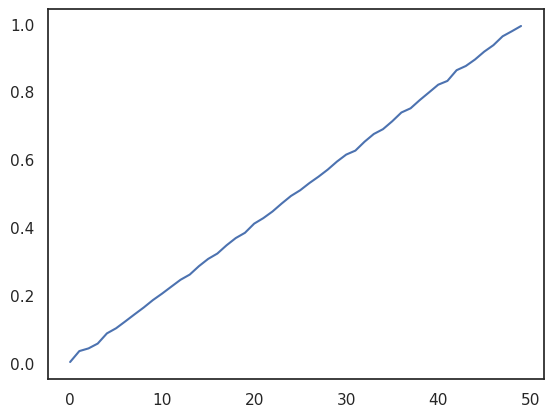

In [228]:
plt.plot(label_hat.detach()) 
# plt.plot(label_i_hat.detach()) 
# plt.plot(label_j_hat.detach()) 
# plt.plot(diff)

In [190]:
label_hat

tensor([[ 0.1134],
        [-0.0182],
        [-0.0065],
        [ 0.0221],
        [ 0.1022],
        [ 0.1187],
        [ 0.1134],
        [ 0.2935],
        [ 0.2721],
        [ 0.1584],
        [ 0.2169],
        [ 0.2276],
        [ 0.2139],
        [ 0.2562],
        [ 0.1954],
        [ 0.3057],
        [ 0.3324],
        [ 0.3842],
        [ 0.3117],
        [ 0.3684],
        [ 0.3717],
        [ 0.4223],
        [ 0.4234],
        [ 0.5454],
        [ 0.5381],
        [ 0.4280],
        [ 0.5968],
        [ 0.6004],
        [ 0.6010],
        [ 0.6033],
        [ 0.6247],
        [ 0.6276],
        [ 0.7140],
        [ 0.7236],
        [ 0.6553],
        [ 0.7300],
        [ 0.7283],
        [ 0.6602],
        [ 0.7959],
        [ 0.7691],
        [ 0.8164],
        [ 0.8549],
        [ 0.9302],
        [ 0.9779],
        [ 0.8747],
        [ 0.9209],
        [ 0.9141],
        [ 0.9462],
        [ 1.0016],
        [ 0.9316]], grad_fn=<AddmmBackward>)

In [184]:
log_filename = 'results/synthetic_C.pkl'
# log_filename = 'results/synthetic_C_0.5.pkl'
if os.path.isfile(log_filename):
    result_log = pd.read_pickle(log_filename)
else:
    result_log = pd.DataFrame() 

In [185]:
result_log['Distortion'] = np.abs(result_log['Pred'])
result_log.describe()

,Theta,Pred,Distortion
count,160000.000000,160000.000000,1.600000e+05
mean,2.891593,0.000217,2.295225e-02
std,1.673646,0.041723,3.484362e-02
min,0.000000,-0.919471,2.384186e-07
25%,1.445796,-0.011380,4.905462e-03
50%,2.891593,-0.001615,1.201027e-02
75%,4.337389,0.012642,2.735978e-02
max,5.783185,0.806581,9.194711e-01


/scratch/local/3195203/ipykernel_92530/479191434.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticks(), size = 13)
/scratch/local/3195203/ipykernel_92530/479191434.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)


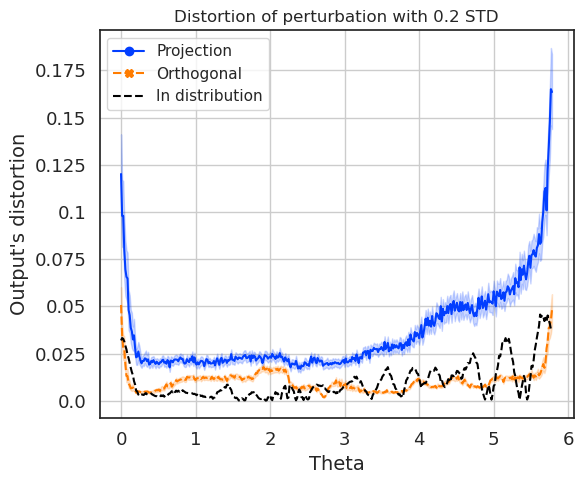

In [267]:
from matplotlib.ticker import NullFormatter

log_filename = 'results/synthetic_C.pkl'
# log_filename = 'results/synthetic_C_0.5.pkl'
if os.path.isfile(log_filename):
    result_log = pd.read_pickle(log_filename)
else:
    result_log = pd.DataFrame() 

result_log['Distortion'] = np.abs(result_log['Pred'])

plt.figure(figsize = (6,5))
sns.set(style='white',)

def formatter(x, pos):
    return str(int(x))

def formatter_y(x, pos):
    return str(round(x, 3))

g = sns.lineplot( x="Theta", y="Distortion", 
                     data=result_log, 
                     hue='Method',
                     style='Method',
#                      err_style="bars",
                     palette = 'bright',
                     markers=True, 
                     markersize=0,
                     legend=True)

g.set(title ='Distortion of perturbation with 0.2 STD')
g.set_xlabel(xlabel ="Theta", size = 14)
g.set_ylabel(ylabel ="Output's distortion", size = 14)
g.set_xticklabels(g.get_xticks(), size = 13)
g.set_yticklabels(g.get_yticks(), size = 13)

g.xaxis.set_major_formatter(formatter)
g.xaxis.set_minor_formatter(NullFormatter())
g.yaxis.set_major_formatter(formatter_y)
g.yaxis.set_minor_formatter(NullFormatter())

plt.grid()

# lgnd = g.legend(title='Input dim',
#           bbox_to_anchor=(1.0, 1.02), fontsize=13, facecolor="gray", framealpha=0.3)

sns.lineplot(x = theta_o, y = diff[:,0], 
             color="black", 
             linestyle='dashed',  
#              marker='s', markersize = 1,
#               sizes = 10, 
             label='In distribution'
            )

plt.tight_layout()

plt.savefig('viz/Distortion_02.pdf')


In [94]:
noise = 0.5
print(noise)
theta_o = np.linspace(0, 2*np.pi-0.5, n)

theta_inc = np.clip(theta_o + noise, 0, 2*np.pi-0.5)
theta_dec = np.clip(theta_o - noise, 0, 2*np.pi-0.5)

xdata_i = r*np.cos(theta_inc)
ydata_i = r*np.sin(theta_inc)*np.cos(phi) 
zdata_i = r*np.sin(theta_inc)*np.sin(phi) + zvert_o

data_i = np.transpose(np.concatenate(([xdata_i],[ydata_i],[zdata_i]), axis=0))
label_i_hat = model(torch.Tensor(data_i)).detach() 

xdata_i = r*np.cos(theta_dec)
ydata_i = r*np.sin(theta_dec)*np.cos(phi) 
zdata_i = r*np.sin(theta_dec)*np.sin(phi) + zvert_o

data_i = np.transpose(np.concatenate(([xdata_i],[ydata_i],[zdata_i]), axis=0))
label_j_hat = model(torch.Tensor(data_i)).detach() 


diff = torch.abs(label_i_hat-label_hat) + torch.abs(label_j_hat-label_hat)
diff = np.abs(diff.detach().numpy())

0.5


/scratch/local/3195203/ipykernel_92530/1726799227.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticks(), size = 13)
/scratch/local/3195203/ipykernel_92530/1726799227.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticks(), size = 13)


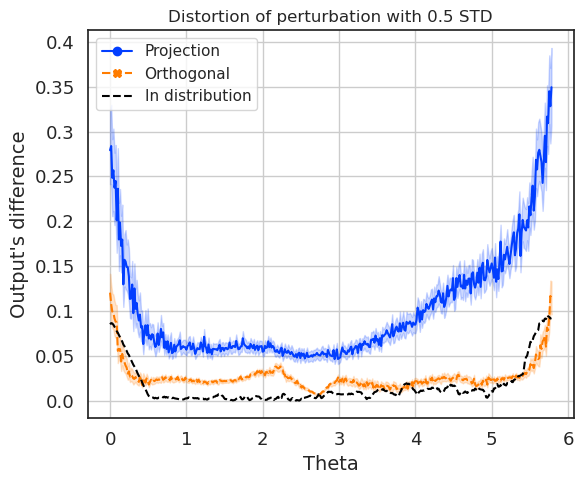

In [261]:
from matplotlib.ticker import NullFormatter

# log_filename = 'results/synthetic_C.pkl'
log_filename = 'results/synthetic_C_0.5.pkl'
if os.path.isfile(log_filename):
    result_log = pd.read_pickle(log_filename)
else:
    result_log = pd.DataFrame() 

result_log['Distortion'] = np.abs(result_log['Pred'])

plt.figure(figsize = (6,5))
sns.set(style='white',)

def formatter(x, pos):
    return str(int(x))

def formatter_y(x, pos):
    return str(round(x, 3))

g = sns.lineplot( x="Theta", y="Distortion", 
                     data=result_log, 
                     hue='Method',
                     style='Method',
#                      err_style="bars",
                     palette = 'bright',
                     markers=True, 
                     markersize=0,
                     legend=True)

g.set(title ='Distortion of perturbation with 0.5 STD')
g.set_xlabel(xlabel ="Theta", size = 14)
g.set_ylabel(ylabel ="Output's difference", size = 14)
g.set_xticklabels(g.get_xticks(), size = 13)
g.set_yticklabels(g.get_yticks(), size = 13)

g.xaxis.set_major_formatter(formatter)
g.xaxis.set_minor_formatter(NullFormatter())
g.yaxis.set_major_formatter(formatter_y)
g.yaxis.set_minor_formatter(NullFormatter())

plt.grid()

# lgnd = g.legend(title='Input dim',
#           bbox_to_anchor=(1.0, 1.02), fontsize=13, facecolor="gray", framealpha=0.3)

sns.lineplot(x = theta_o, y = diff[:,0], 
             color="black", 
             linestyle='dashed',  
#              marker='s', markersize = 1,
#               sizes = 10, 
             label='In distribution'
            )

plt.tight_layout()
plt.savefig('viz/Distortion_05.pdf')

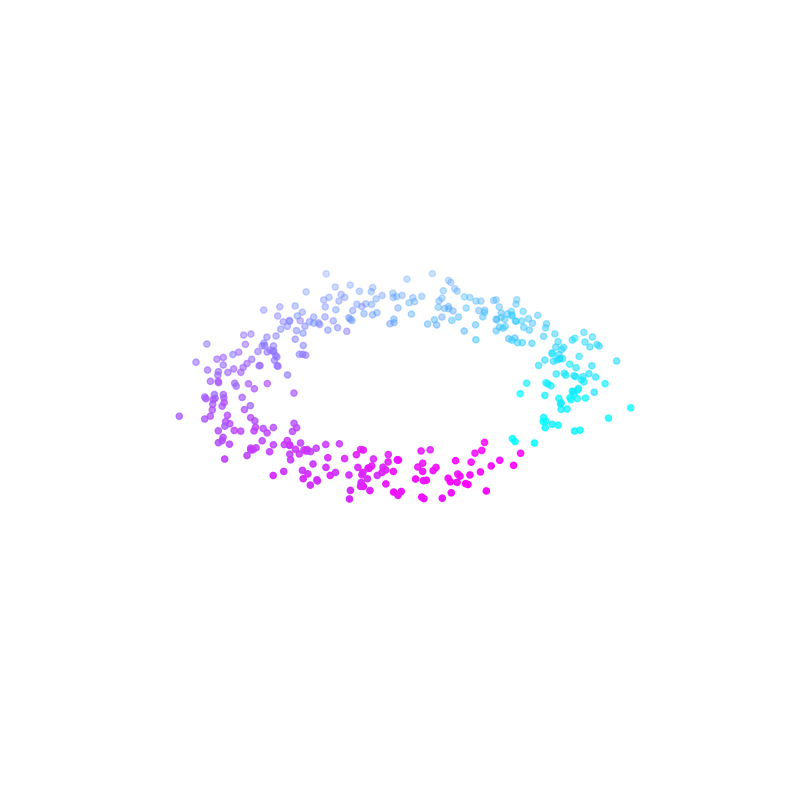

In [15]:
noise = 0.001
noise_z = 0.2

theta_o = np.linspace(0, 2*np.pi-0.5, n)
noise_x = noise_z/np.sqrt(2)
noise_y = noise_z/np.sqrt(2)
zvert_o = np.linspace(0, 0, n)

xdata_o = r*np.cos(theta_o) + noise_x * np.random.randn(n)
ydata_o = r*np.sin(theta_o)*np.cos(phi) + noise_y * np.random.randn(n)
zdata_o = r*np.sin(theta_o)*np.sin(phi) + noise * np.random.randn(n) + zvert_o

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(xdata_o, ydata_o, zdata_o, c=theta_o, cmap='cool');
ax.axes.set_zlim3d(bottom=-0.6, top=0.6) 

ax.axis('off')

plt.savefig('viz/syn_Cp_02.pdf')

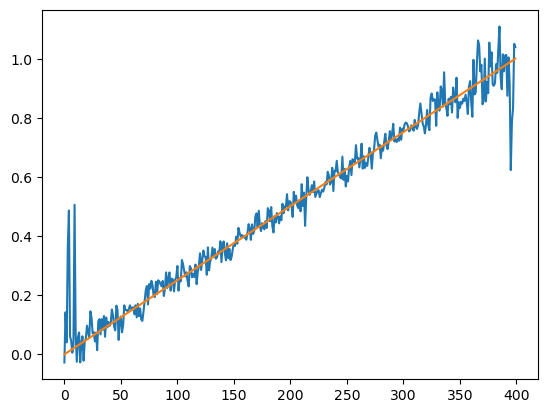

In [16]:
data_o = np.transpose(np.concatenate(([xdata_o],[ydata_o],[zdata_o]), axis=0))
label_o_hat = model(torch.Tensor(data_o))

plt.plot(label_o_hat.detach())
plt.plot(label)

In [77]:
np.linalg.norm(noise_x/np.sqrt(2) * np.random.randn(n) + noise_x/np.sqrt(2) * np.random.randn(n))

1.979012038339032

In [55]:
class LinearRegressionModel(torch.nn.Module):
 
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(3, 1)  # One in and one out
 
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [62]:
ex_model = LinearRegressionModel()

ex_criterion = torch.nn.MSELoss(size_average = False)
ex_optimizer = torch.optim.SGD(ex_model.parameters(), lr = 0.001)


for epoch in range(500):
    ex_optimizer.zero_grad()
    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y = ex_model(torch.Tensor(data_o))
 
    # Compute and print loss
    loss = ex_criterion(pred_y, label_o_hat.detach())
 
    # Zero gradients, perform a backward pass,
    # and update the weights.
#     ex_optimizer.zero_grad()
    loss.backward()
    ex_optimizer.step()
    if epoch % 50 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 205.49600219726562
epoch 50, loss 8.929961204528809
epoch 100, loss 8.929917335510254
epoch 150, loss 8.929874420166016
epoch 200, loss 8.929830551147461
epoch 250, loss 8.929788589477539
epoch 300, loss 8.9297456741333
epoch 350, loss 8.929703712463379
epoch 400, loss 8.929661750793457
epoch 450, loss 8.929619789123535


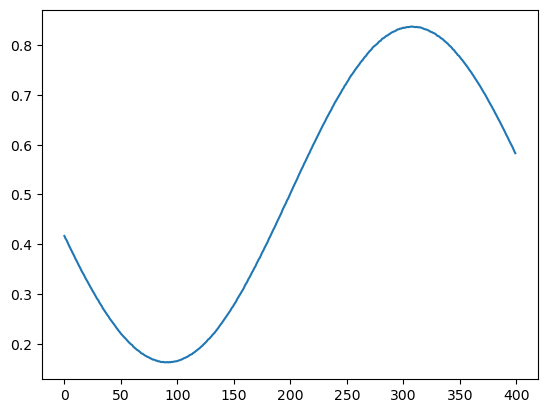

In [63]:
plt.plot(pred_y.detach())